# Step 3: Classify Diagonal, Horizontal, Vertical, Web

## 0. Imports & Global Setting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets

from PIL import Image
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
SEED = 1220
BATCH_SIZE = 64
NUM_CLASSES = 4
EPOCHS = 30
IMAGE_SIZE = 224
LEARNING_RATE = 0.0001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "../data/crack_classification"
LABEL_DIR = "../output/damage_detection/predictions/labels"
TEST_DIR = "../data/test"
CSV_FILE = "../output/damage_classification/submission.csv"
FILE_EXTENSIONS = (".jpg", ".jpeg", ".png")

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
torch.cuda.empty_cache()

In [5]:
print(f"Using device: {DEVICE}")
print(f"Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Using Pytorch version: {torch.__version__}")
print(f"Using CUDA version: {torch.version.cuda}")
print(f"Using cuDNN version: {torch.backends.cudnn.version()}")

Using device: cuda
Using GPU: NVIDIA GeForce RTX 4070
Using Pytorch version: 2.7.0+cu128
Using CUDA version: 12.8
Using cuDNN version: 90701


## 1. Dataset / DataLoader

In [6]:
transform_train = T.Compose(
    [
        T.Resize(int(IMAGE_SIZE * 1.15)),
        T.RandomCrop(IMAGE_SIZE, padding=int(IMAGE_SIZE * 0.15)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        T.RandomRotation(15),
        T.ToTensor(),
        T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=IMAGENET_MEAN),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
def load_dataset(data_dir, batch_size, split_ratio=0.8):
    dataset = datasets.ImageFolder(data_dir, transform=transform_train)
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [8]:
trainloader, valloader = load_dataset(DATA_DIR, BATCH_SIZE)

## 2. Define Model

In [9]:
from torchvision.models import efficientnet_v2_s


class EfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2, self).__init__()
        self.model = efficientnet_v2_s(weights="DEFAULT")
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = EfficientNetV2(NUM_CLASSES).to(DEVICE)

## 3. Train & Validate

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss

        elif val_loss > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

        else:
            self.best_score = val_loss
            self.counter = 0
            torch.save(model.state_dict(), "../output/crack_classification/models/best_model.pth")
            if self.verbose:
                print(f"✅ Model saved with loss: {val_loss:.4f}")

        return self.early_stop

In [11]:
def train(model, trainloader, valloader, epochs):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=7, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()
        # scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        print("-" * 60)

        if early_stopping(val_loss, model):
            print("Early stopping")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES
    cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int32)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
                cm[label, pred] += 1

    accuracy = correct / total
    return accuracy, class_correct, class_total, cm

In [13]:
print("Training the model...")
train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, EPOCHS)

Training the model...


Epoch 1/30: 100%|██████████| 9/9 [00:10<00:00,  1.14s/batch]


Train Loss: 1.3680, Train Acc: 0.3188%
Validation Loss: 1.3976, Val Acc: 0.3409%
------------------------------------------------------------


Epoch 2/30: 100%|██████████| 9/9 [00:09<00:00,  1.03s/batch]


Train Loss: 1.3236, Train Acc: 0.3681%
Validation Loss: 1.3213, Val Acc: 0.3788%
------------------------------------------------------------
✅ Model saved with loss: 1.3213


Epoch 3/30: 100%|██████████| 9/9 [00:16<00:00,  1.78s/batch]


Train Loss: 1.2609, Train Acc: 0.4535%
Validation Loss: 1.2792, Val Acc: 0.4242%
------------------------------------------------------------
✅ Model saved with loss: 1.2792


Epoch 4/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 1.1670, Train Acc: 0.4934%
Validation Loss: 1.1128, Val Acc: 0.4470%
------------------------------------------------------------
✅ Model saved with loss: 1.1128


Epoch 5/30: 100%|██████████| 9/9 [00:09<00:00,  1.06s/batch]


Train Loss: 1.1125, Train Acc: 0.5560%
Validation Loss: 1.0995, Val Acc: 0.5379%
------------------------------------------------------------
✅ Model saved with loss: 1.0995


Epoch 6/30: 100%|██████████| 9/9 [00:16<00:00,  1.79s/batch]


Train Loss: 1.0811, Train Acc: 0.5882%
Validation Loss: 0.9966, Val Acc: 0.6061%
------------------------------------------------------------
✅ Model saved with loss: 0.9966


Epoch 7/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 0.9828, Train Acc: 0.6376%
Validation Loss: 1.0865, Val Acc: 0.6136%
------------------------------------------------------------


Epoch 8/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 0.9686, Train Acc: 0.6584%
Validation Loss: 0.9333, Val Acc: 0.6667%
------------------------------------------------------------
✅ Model saved with loss: 0.9333


Epoch 9/30: 100%|██████████| 9/9 [00:09<00:00,  1.10s/batch]


Train Loss: 0.9632, Train Acc: 0.6736%
Validation Loss: 0.9955, Val Acc: 0.6439%
------------------------------------------------------------


Epoch 10/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 0.9102, Train Acc: 0.6831%
Validation Loss: 1.0099, Val Acc: 0.5985%
------------------------------------------------------------


Epoch 11/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 0.8754, Train Acc: 0.7211%
Validation Loss: 0.9867, Val Acc: 0.6515%
------------------------------------------------------------


Epoch 12/30: 100%|██████████| 9/9 [00:09<00:00,  1.04s/batch]


Train Loss: 0.8725, Train Acc: 0.7306%
Validation Loss: 0.9140, Val Acc: 0.6667%
------------------------------------------------------------
✅ Model saved with loss: 0.9140


Epoch 13/30: 100%|██████████| 9/9 [00:09<00:00,  1.08s/batch]


Train Loss: 0.8395, Train Acc: 0.7324%
Validation Loss: 0.7865, Val Acc: 0.7273%
------------------------------------------------------------
✅ Model saved with loss: 0.7865


Epoch 14/30: 100%|██████████| 9/9 [00:09<00:00,  1.07s/batch]


Train Loss: 0.8468, Train Acc: 0.7306%
Validation Loss: 0.9667, Val Acc: 0.5985%
------------------------------------------------------------


Epoch 15/30: 100%|██████████| 9/9 [00:09<00:00,  1.03s/batch]


Train Loss: 0.8474, Train Acc: 0.7381%
Validation Loss: 0.7825, Val Acc: 0.7121%
------------------------------------------------------------
✅ Model saved with loss: 0.7825


Epoch 16/30: 100%|██████████| 9/9 [00:03<00:00,  2.72batch/s]


Train Loss: 0.8067, Train Acc: 0.7723%
Validation Loss: 0.8260, Val Acc: 0.6591%
------------------------------------------------------------


Epoch 17/30: 100%|██████████| 9/9 [00:09<00:00,  1.06s/batch]


Train Loss: 0.8182, Train Acc: 0.7495%
Validation Loss: 1.0969, Val Acc: 0.5909%
------------------------------------------------------------


Epoch 18/30: 100%|██████████| 9/9 [00:09<00:00,  1.07s/batch]


Train Loss: 0.7692, Train Acc: 0.7799%
Validation Loss: 0.8321, Val Acc: 0.7500%
------------------------------------------------------------


Epoch 19/30: 100%|██████████| 9/9 [00:09<00:00,  1.03s/batch]


Train Loss: 0.7522, Train Acc: 0.7856%
Validation Loss: 0.9181, Val Acc: 0.7121%
------------------------------------------------------------


Epoch 20/30: 100%|██████████| 9/9 [00:03<00:00,  2.60batch/s]


Train Loss: 0.7388, Train Acc: 0.8083%
Validation Loss: 1.0950, Val Acc: 0.7045%
------------------------------------------------------------


Epoch 21/30: 100%|██████████| 9/9 [00:09<00:00,  1.06s/batch]


Train Loss: 0.8150, Train Acc: 0.7533%
Validation Loss: 1.0073, Val Acc: 0.6667%
------------------------------------------------------------


Epoch 22/30: 100%|██████████| 9/9 [00:09<00:00,  1.03s/batch]


Train Loss: 0.7176, Train Acc: 0.7932%
Validation Loss: 1.0136, Val Acc: 0.6364%
------------------------------------------------------------
Early stopping triggered.
Early stopping


In [14]:
print("Evaluating the model...")
val_accuracy, val_class_correct, val_class_total, val_cm = evaluate(model, valloader)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Evaluating the model...
Validation Accuracy: 0.7500


In [15]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 4. Evaluation & Visualization

In [16]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig('../output/crack_classification/images/training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [17]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    classes = ['Diagonal', 'Horizontal', 'Vertical', 'Web']
    num_classes = len(classes)

    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []

    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')

    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../output/crack_classification/images/per_class_accuracy.png')
    plt.show()

    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone().float()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(
                j,
                i,
                f'{normalized_confusion_matrix[i, j]:.2f}',
                horizontalalignment="center",
                color="white" if normalized_confusion_matrix[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../output/crack_classification/images/confusion_matrix.png')
    plt.show()

    return

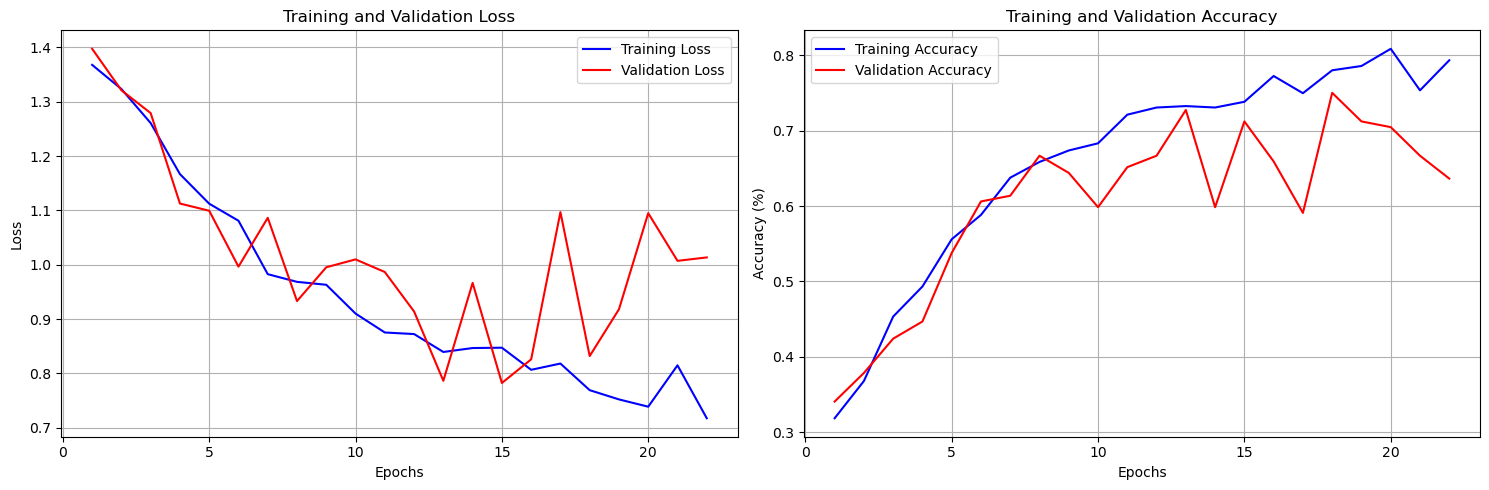

Training metrics plot saved as 'training_metrics.png'

Per-class Accuracy:
--------------------------------------------------
Diagonal: 51.72% (15/29)
Horizontal: 89.19% (33/37)
Vertical: 83.33% (35/42)
Web: 66.67% (16/24)


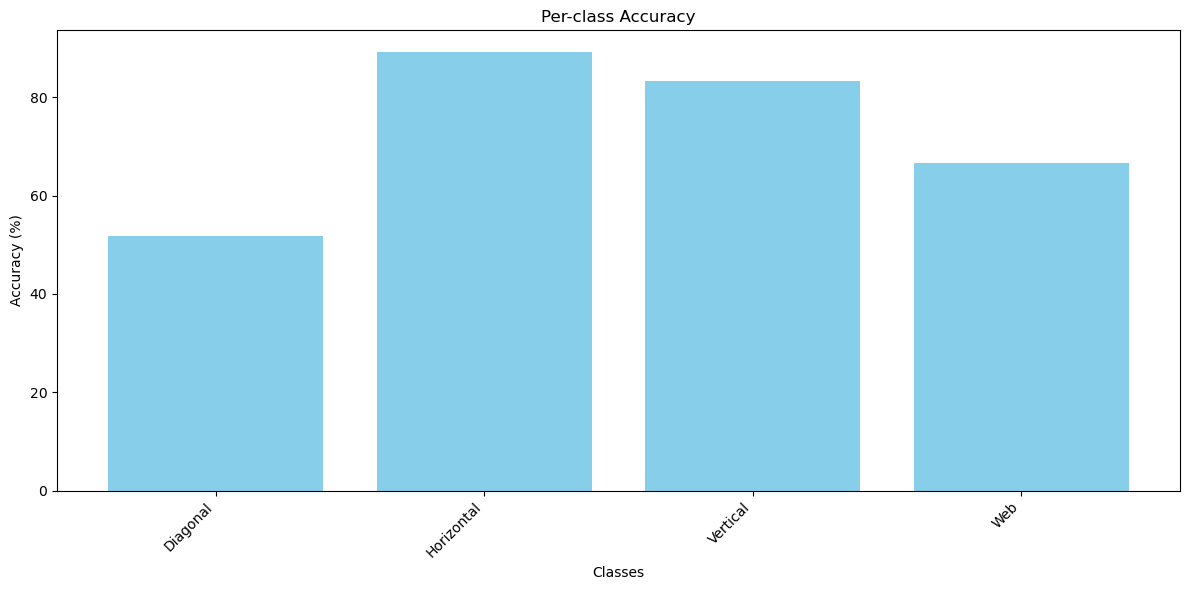

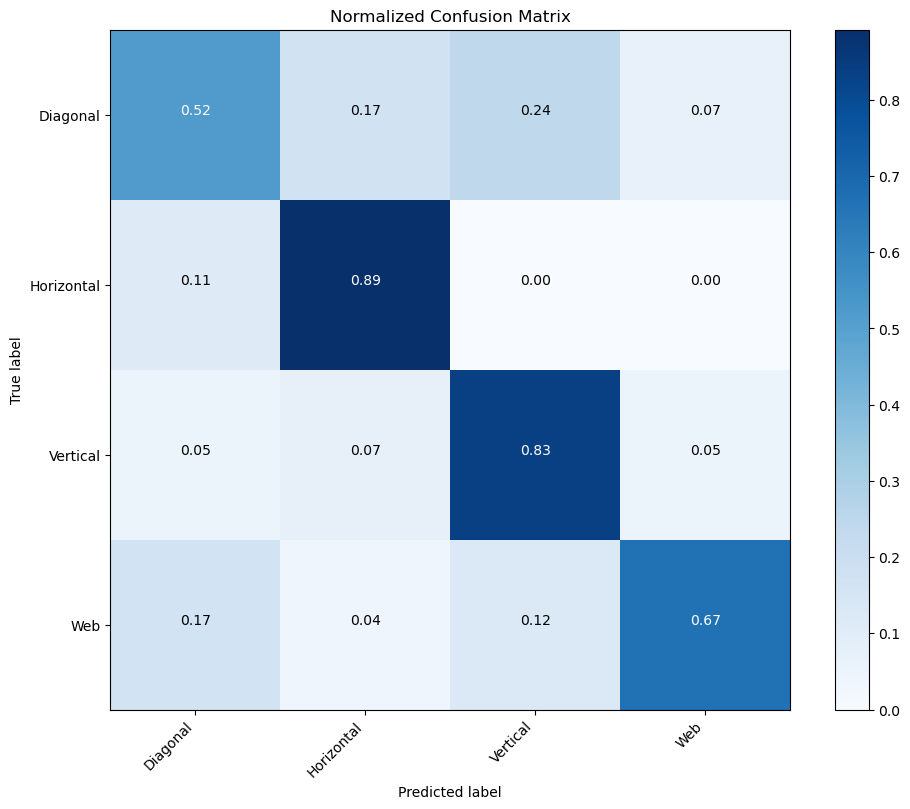

In [18]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
plot_evaluation_metrics(val_class_correct, val_class_total, val_cm)

## 5. Prediction & Submission

In [27]:
CRACK_CLASSES = ["diagonal", "horizontal", "vertical", "web"]

In [28]:
import cv2


def yolo_to_xyxy(img_h, img_w, xc, yc, w, h):
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    return max(x1, 0), max(y1, 0), min(x2, img_w - 1), min(y2, img_h - 1)


def crop_and_resize(img, box, out_size=224):
    x1, y1, x2, y2 = box
    patch = img[y1:y2, x1:x2]
    return cv2.resize(patch, (out_size, out_size), interpolation=cv2.INTER_AREA)

In [29]:
df = pd.read_csv(CSV_FILE)

for cls in CRACK_CLASSES:
    df[cls] = 0

df.head()

,ID,class,diagonal,horizontal,vertical,web
0,1,C,0,0,0,0
1,2,C,0,0,0,0
2,3,B,0,0,0,0
3,4,B,0,0,0,0
4,5,A,0,0,0,0


In [30]:
from pathlib import Path

model.load_state_dict(torch.load("../output/crack_classification/models/best_model.pth"))
model.to(DEVICE)
model.eval()

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing test images"):
    img_id = str(int(row["ID"] if "ID" in df.columns else row[0]))
    img_path = Path(TEST_DIR) / f"{img_id}.jpg"
    label_path = Path(LABEL_DIR) / f"{img_id}.txt"

    if not img_path.exists() or not label_path.exists():
        continue

    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        for ln in f:
            cls_id, xc, yc, bw, bh = map(float, ln.split())
            if int(cls_id) != 1:
                continue

            box = yolo_to_xyxy(h, w, xc, yc, bw, bh)
            patch = crop_and_resize(img, box, out_size=IMAGE_SIZE)
            patch = Image.fromarray(patch)
            patch = transform_train(patch).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                output = model(patch)
                _, predicted = torch.max(output, 1)
                cls_name = CRACK_CLASSES[predicted.item()]
            df.loc[df["ID"] == int(img_id), cls_name] = 1

df.to_csv("../output/crack_classification/submission.csv", index=False)

Processing test images: 100%|██████████| 50/50 [00:01<00:00, 35.02it/s]
